# Model Evaluation

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc

## Dataset Transformation and Custom DataLoader

This section prepares the data for model validation and defines a custom dataset class.

- **Validation Transform**: Resizes, center-crops, normalizes, and converts images to tensors using standard ImageNet preprocessing.

- **`SkinDiseaseDataset` Class**:
  - Custom PyTorch dataset to load skin disease images and their corresponding labels.
  - Supports applying transformations.
  - Includes error handling: retries loading an image up to 5 times and returns a dummy image if all attempts fail.

In [2]:
# Define transforms for validation
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset class (same as in your training script)
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_paths, class_labels, class_to_idx, transform=None):
        """
        Custom dataset for skin disease classification.
        
        Args:
            image_paths (list): List of paths to the images
            class_labels (list): List of class labels (strings) corresponding to the images
            class_to_idx (dict): Mapping from class names to indices
            transform (callable, optional): Optional transform to be applied on images
        """
        self.image_paths = image_paths
        self.class_labels = class_labels
        self.class_to_idx = class_to_idx
        self.transform = transform
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 5
        
        while attempts < max_attempts:
            try:
                # Get image path and label
                img_path = self.image_paths[idx]
                class_name = self.class_labels[idx]
                
                # Convert string label to integer index
                label = self.class_to_idx[class_name]
                
                # Load and process image
                image = Image.open(img_path).convert('RGB')
                
                # Apply transformations
                if self.transform:
                    image = self.transform(image)
                    
                return image, label
                
            except Exception as e:
                print(f"Error opening image: {img_path}. Trying another image. Error: {e}")
                attempts += 1
                if attempts >= max_attempts:
                    # Return a black image as fallback
                    print(f"Failed to load image after {max_attempts} attempts.")
                    dummy_img = torch.zeros(3, 224, 224)
                    return dummy_img, 0  # Return 0 as fallback label
                
                # Try a different random image
                idx = np.random.randint(0, len(self.image_paths) - 1)

## Image Path Extraction Utility

Defines a function to traverse the dataset directory and collect image file paths along with their corresponding class labels.

- Takes a root dataset path as input.
- Assumes each subfolder represents a class.
- Filters valid image files by extension and stores their paths and labels.

In [3]:
# Function to get image file paths (adapt to your file structure)
def get_image_paths(dataset_path):
    class_folders = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) 
                     if os.path.isdir(os.path.join(dataset_path, d))]
    image_paths = []
    class_labels = []
    
    for class_folder in class_folders:
        label = os.path.basename(class_folder)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if img_path.endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(img_path)
                class_labels.append(label)
    
    return image_paths, class_labels

## Validation Data Loader Setup

Defines a function to prepare the validation dataset and DataLoader.

- Splits the dataset based on a specified ratio (default 20%) for validation.
- Maps class labels to numeric indices.
- Uses the `SkinDiseaseDataset` class with predefined transforms.
- Returns a PyTorch `DataLoader` for efficient batch loading during model evaluation.

In [4]:
# Function to load the validation dataset
def load_validation_data(dataset_path, train_test_split_ratio=0.2, batch_size=32):
    # Load image paths and labels
    image_paths, class_labels = get_image_paths(dataset_path)
    
    # Get unique class names
    unique_classes = sorted(set(class_labels))
    
    # Create mapping dictionary
    class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_classes)}
    
    # Get validation indices
    np.random.seed(42)  # Set seed for reproducibility
    indices = np.arange(len(image_paths))
    np.random.shuffle(indices)
    
    val_size = int(len(indices) * train_test_split_ratio)
    val_indices = indices[:val_size]
    
    # Create validation dataset
    val_image_paths = [image_paths[i] for i in val_indices]
    val_labels = [class_labels[i] for i in val_indices]
    
    val_dataset = SkinDiseaseDataset(
        image_paths=val_image_paths, 
        class_labels=val_labels,
        class_to_idx=class_to_idx, 
        transform=val_transform
    )
    
    # Create data loader
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    
    return val_loader, class_to_idx

## Model Loading and Initialization

Defines a function to load a pretrained EfficientNet-B3 model for inference.

- Initializes the model architecture and adjusts the final classifier layer for the desired number of output classes.
- Loads saved weights from the specified path.
- Moves the model to the specified device (CPU/GPU) and sets it to evaluation mode.

In [5]:
# Load and initialize the model
def load_model(model_path, num_classes, device):
    # Initialize the model
    model = models.efficientnet_b3(weights=None)
    
    # Modify the classifier for the correct number of classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_features, num_classes)
    
    # Load the weights
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Move model to device
    model = model.to(device)
    model.eval()
    
    return model

In [6]:
# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
    return accuracy, all_preds, all_labels, all_probs

In [7]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Normalized confusion matrix
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15, 15))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('normalized_confusion_matrix.png')
    plt.show()

# Generate classification report
def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Save to CSV
    report_df.to_csv('classification_report.csv')
    
    # Visualization
    plt.figure(figsize=(12, 8))
    report_display = report_df.iloc[:-3, :3].copy()  # Remove avg/total rows and support column
    sns.heatmap(report_display, annot=True, cmap="Blues")
    plt.title('Classification Report Heatmap')
    plt.tight_layout()
    plt.savefig('classification_report_heatmap.png')
    plt.show()
    
    return report_df

In [8]:
# Class-wise accuracy
def calculate_class_accuracy(y_true, y_pred, class_names):
    class_accuracy = {}
    for i, class_name in enumerate(class_names):
        class_indices = [j for j, x in enumerate(y_true) if x == i]
        if class_indices:
            correct = sum(1 for j in class_indices if y_pred[j] == y_true[j])
            class_accuracy[class_name] = 100 * correct / len(class_indices)
        else:
            class_accuracy[class_name] = 0
    
    # Plot class accuracy
    plt.figure(figsize=(15, 10))
    classes = list(class_accuracy.keys())
    accuracies = list(class_accuracy.values())
    
    # Sort by accuracy for better visualization
    sorted_indices = np.argsort(accuracies)
    sorted_classes = [classes[i] for i in sorted_indices]
    sorted_accuracies = [accuracies[i] for i in sorted_indices]
    
    bars = plt.barh(sorted_classes, sorted_accuracies, color='skyblue')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Class')
    plt.title('Class-wise Accuracy')
    plt.xlim(0, 100)
    
    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        plt.text(min(width + 2, 95), bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                 va='center', ha='left')
    
    plt.tight_layout()
    plt.savefig('class_accuracy.png')
    plt.show()
    
    # Save to CSV
    acc_df = pd.DataFrame({
        'Class': classes,
        'Accuracy (%)': accuracies
    })
    acc_df.to_csv('class_accuracy.csv', index=False)
    
    return class_accuracy

In [13]:
# ROC curves for multiclass
def plot_roc_curves(y_true, y_probs, class_names):
    # Convert to one-vs-rest format
    y_true_binary = np.zeros((len(y_true), len(class_names)))
    for i in range(len(y_true)):
        y_true_binary[i, y_true[i]] = 1
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(20, 8))
    
    # Only plot ROC curves for classes with sufficient samples
    valid_classes = []
    
    for i, class_name in enumerate(class_names):
        if sum(y_true_binary[:, i]) > 0:  # Check if class has samples
            fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], np.array(y_probs)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            valid_classes.append(i)
            
            # Thinning out points for clearer visualization
            if len(fpr[i]) > 50:
                step = len(fpr[i]) // 50
                plt.plot(fpr[i][::step], tpr[i][::step], lw=2, 
                         label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
            else:
                plt.plot(fpr[i], tpr[i], lw=2,
                         label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    # Calculate and plot micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), np.array(y_probs).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr["micro"], tpr["micro"], 
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='red', linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()
    
    # Save AUC scores to CSV
    auc_df = pd.DataFrame({
        'Class': [class_names[i] for i in valid_classes] + ['Micro-average'],
        'AUC': [roc_auc[i] for i in valid_classes] + [roc_auc["micro"]]
    })
    auc_df.to_csv('roc_auc_scores.csv', index=False)
    
    return roc_auc

In [10]:
def analyze_misclassifications(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate error rates for each class
    error_rates = {}
    for i, class_name in enumerate(class_names):
        # Convert y_true to a numpy array if it's not already
        y_true_np = np.array(y_true)
        # Count instances where true label is i
        count = np.sum(y_true_np == i)
        if count > 0:  # Avoid division by zero
            error_rates[class_name] = 100 - (100 * cm[i, i] / count)
        else:
            error_rates[class_name] = 0
    
    # Sort by error rate
    sorted_error_rates = {k: v for k, v in sorted(error_rates.items(), key=lambda item: item[1], reverse=True)}
    
    # Visualize top 10 most misclassified classes
    plt.figure(figsize=(12, 8))
    top_classes = list(sorted_error_rates.keys())[:10]
    top_errors = [sorted_error_rates[cls] for cls in top_classes]
    
    bars = plt.barh(top_classes, top_errors, color='salmon')
    plt.xlabel('Error Rate (%)')
    plt.ylabel('Class')
    plt.title('Top 10 Most Misclassified Classes')
    
    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        plt.text(min(width + 2, 95), bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                 va='center', ha='left')
    
    plt.tight_layout()
    plt.savefig('top_misclassified_classes.png')
    plt.show()
    
    # Find most common misclassifications
    misclassification_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                misclassification_pairs.append({
                    'True': class_names[i],
                    'Predicted': class_names[j],
                    'Count': int(cm[i, j]),
                    'Error Rate': 100 * cm[i, j] / np.sum(y_true_np == i) if np.sum(y_true_np == i) > 0 else 0
                })
    
    # Sort by count
    misclassification_pairs = sorted(misclassification_pairs, key=lambda x: x['Count'], reverse=True)
    
    # Save to CSV
    misclass_df = pd.DataFrame(misclassification_pairs)
    misclass_df.to_csv('common_misclassifications.csv', index=False)
    
    # Display top 10
    print("Top 10 Most Common Misclassifications:")
    for i, pair in enumerate(misclassification_pairs[:10]):
        print(f"{i+1}. True: {pair['True']} → Predicted: {pair['Predicted']} ({pair['Count']} instances, {pair['Error Rate']:.1f}% of the class)")
    
    return misclassification_pairs

In [11]:
# Function to visualize model predictions on sample images
def visualize_predictions(model, dataloader, class_names, device, num_samples=10):
    model.eval()
    images = []
    true_labels = []
    pred_labels = []
    probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            if len(images) >= num_samples:
                break
                
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)
            
            for i in range(inputs.size(0)):
                if len(images) < num_samples:
                    images.append(inputs[i].cpu())
                    true_labels.append(labels[i].item())
                    pred_labels.append(predictions[i].item())
                    probs.append(probabilities[i, predictions[i]].item())
                else:
                    break
    
    # Create a figure to display the images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    # Inverse normalization function
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean
    
    # Display the images
    for i, (img, true_label, pred_label, prob) in enumerate(zip(images, true_labels, pred_labels, probs)):
        img = denormalize(img)
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img.permute(1, 2, 0))
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {prob:.2f}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

Using device: cuda
Loading validation data...
Loading model from best_model-1.pth...
Evaluating model...
Validation Accuracy: 96.79%
Generating ROC curves...


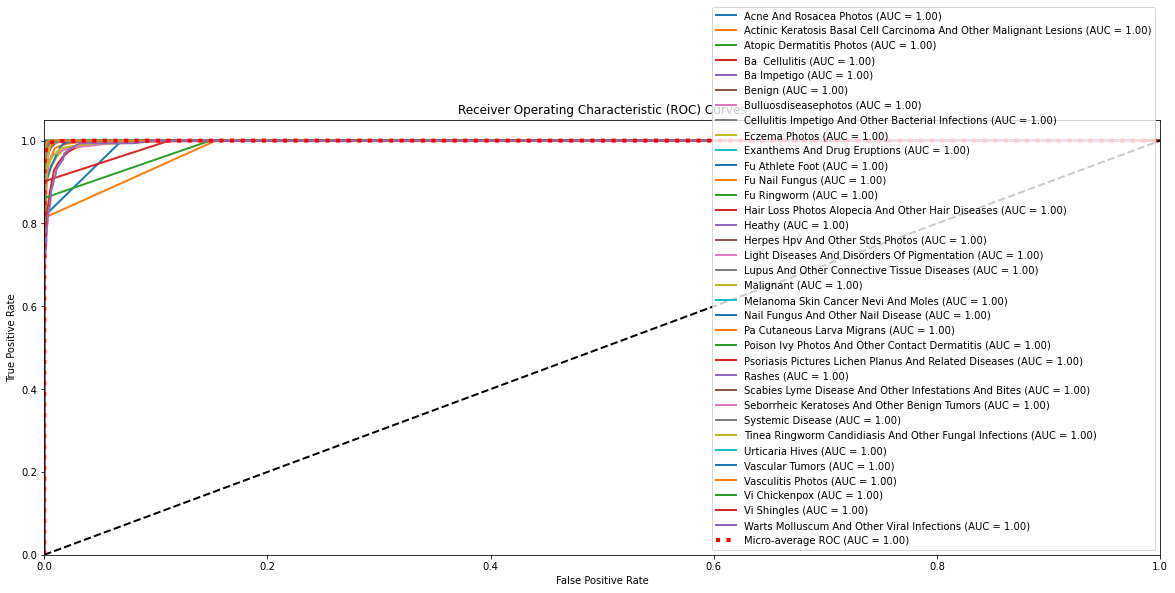

In [14]:
# Main evaluation function
def main():
    # Configuration
    DATASET_PATH = "/scratch/panchani.d/Hpc/dataset"  # Change this to your dataset path
    MODEL_PATH = "best_model-1.pth"  # Change to your model path
    BATCH_SIZE = 64
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load validation data
    print("Loading validation data...")
    val_loader, class_to_idx = load_validation_data(DATASET_PATH, batch_size=BATCH_SIZE)
    
    # Convert class indices to names
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in range(len(class_to_idx))]
    
    # Load model
    print(f"Loading model from {MODEL_PATH}...")
    model = load_model(MODEL_PATH, len(class_to_idx), device)
    
    # Run evaluation
    print("Evaluating model...")
    accuracy, all_preds, all_labels, all_probs = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy: {accuracy:.2f}%")
    
    # Plot confusion matrix
    print("Generating confusion matrix...")
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Print classification report
    print("Generating classification report...")
    report_df = print_classification_report(all_labels, all_preds, class_names)
    print(report_df)
    
    # Calculate class-wise accuracy
    print("Calculating class-wise accuracy...")
    class_accuracy = calculate_class_accuracy(all_labels, all_preds, class_names)
    
    # Plot ROC curves
    print("Generating ROC curves...")
    try:
        roc_auc_scores = plot_roc_curves(all_labels, all_probs, class_names)
    except Exception as e:
        print(f"Error generating ROC curves: {e}")
    
    # Analyze misclassifications
    print("Analyzing misclassifications...")
    misclassifications = analyze_misclassifications(all_labels, all_preds, class_names)
    
    # Visualize model predictions
    print("Visualizing model predictions on sample images...")
    visualize_predictions(model, val_loader, class_names, device)
    
    # Save all evaluation metrics to a summary file
    summary = {
        'accuracy': accuracy,
        'top_class_accuracy': max(class_accuracy.values()),
        'bottom_class_accuracy': min(class_accuracy.values()),
        'micro_avg_auc': roc_auc_scores.get('micro', 0) if 'roc_auc_scores' in locals() else 0
    }
    
    summary_df = pd.DataFrame([summary])
    summary_df.to_csv('evaluation_summary.csv', index=False)
    
    print("Evaluation complete! All results have been saved as CSV files and visualizations.")

if __name__ == "__main__":
    main()